<a href="https://colab.research.google.com/github/GuangShuaiWang/Colabnotebook/blob/main/Tensorflow_Basic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 创建回归模型
  之前接触到的一些全部都是分类型的问题，构建的模型也是分类模型。但是在回归问题中，我们的目的是去预测一些连续的输出值，因此相应的一些loss函数，metric精度的设置，还有就是判断模型好还的方法可能就不再适用，比如ROC曲线等，所以这里需要先建立一些简单的概念。

  这里全部的内容是来源于Tensorflow中的相关内容的[教程](https://www.tensorflow.org/tutorials/keras/regression)，首先完整的走下来，有一些简单的理解。这篇教程的概述就是：使用Auto MPG数据集，构建预测70-80年代汽车燃油效率的模型。

In [ ]:
import pathlib #类似os，用于路径操作

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.7.0


## 首先是数据集的处理

### 数据导入

In [ ]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
# tf.keras.utils感觉会有很多好用的工具，可以去探索一下，昨天接触到的plotmodel可以绘制模型架构，很好用。
dataset_path

40960/30286 [========================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
#定义列名，可以在读入文件时通过names指定。
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy() #通过.copy()方法才能指向不同的内存
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 数据清洗

In [ ]:
dataset.isna().sum() #这段命令很好用，is.na方法可以判断每个cell是否为nana，返回True 1，False 0。通过sum方法可以加起来，既是na的个数

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()

将类型变成独热码的方式。

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 数据集的划分

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#这里也是一种划分的思路，通过df.sample(frac=)的方式划分出一定比例。
#train_test_split使用的更多的地方应该是np数组的划分

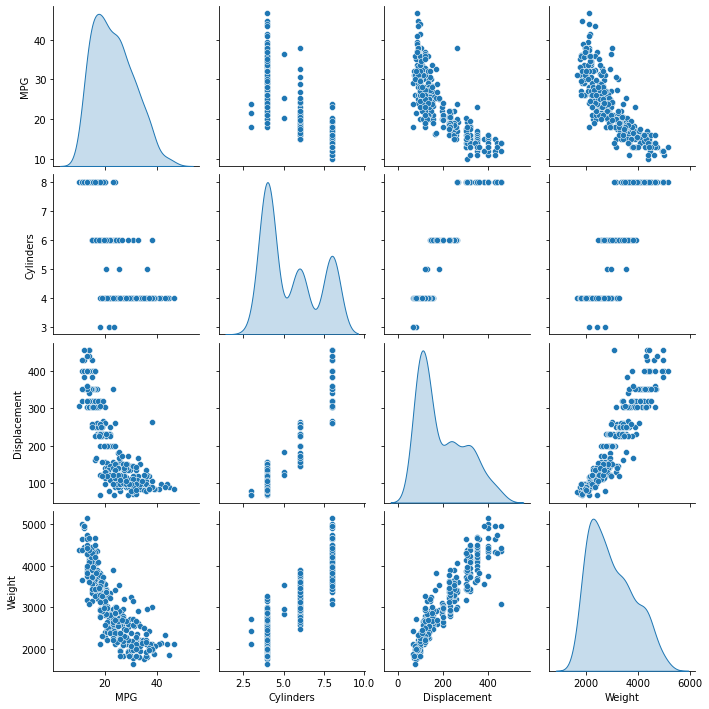

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
#通过seaborn绘图，简单，优雅，快捷。但不够定制化。

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()#列表转置
train_stats
#这里的思路也可以借鉴，没想到对于describe来说进行转置后意外的易读

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 分离出特征

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 数据的归一化
为了避免由于不同数据的尺度和范围对模型产生影响，我们需要对数据进行转换，转化的方式在李沐老师的一节课中提到过，具体我忘了，可以再去看一下。这里使用的是归一化的方式，即减去均值除以标准差。

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## 模型
sequential的方式构建模型，另一种方式是fuctional API。

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

使用非常小的数量来去验证模型能否工作，可以的话再去做全部的数据集

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1268368 ],
       [-0.02493485],
       [-0.01301551],
       [-0.20866953],
       [ 0.01283467],
       [-0.15821415],
       [-0.01657259],
       [ 0.32456094],
       [-0.00116343],
       [ 0.18522452]], dtype=float32)

In [29]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

训练完成后的结果都存储在history对象中，对history进行分析，对训练过程进行可视化。

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch#默认的historyhistory.history字典中不会有epoch，所以要自己创建
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.905070,1.097276,2.905070,8.584039,2.217641,8.584039,995
996,2.712307,1.018343,2.712307,8.149724,2.158825,8.149724,996
997,2.926994,1.098782,2.926994,8.623758,2.251248,8.623758,997
998,2.841443,1.057160,2.841443,8.276957,2.180775,8.276957,998
999,2.821282,1.073006,2.821282,8.537876,2.231925,8.537876,999


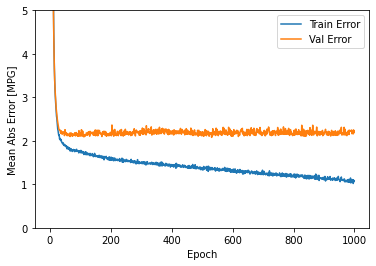

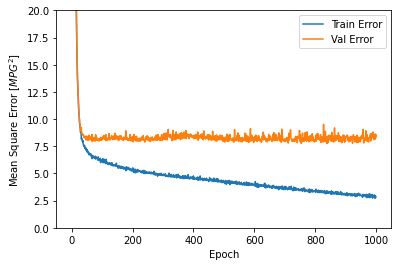

In [31]:
def plot_history(history):#是我不喜欢的绘图方式
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

由上图的结果看出训练到一定程度之后，结果不在变化，所以需要设计Earlystopping来提前终止训练。


.....................................................................

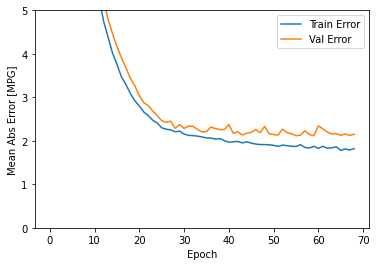

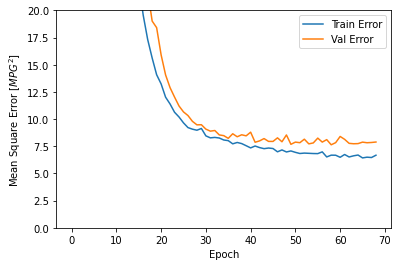

In [33]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)#设定需要监控的要素与监控的步长

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [34]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7948 - mae: 1.9340 - mse: 5.7948 - 20ms/epoch - 7ms/step
Testing set Mean Abs Error:  1.93 MPG


在测试集上可以去查看我们模型的泛化效果。

这里就跟我之前建立的autoencoder一个思路，查看预测前后的变化，并且可以计算它们的pearsonr 系数，来看两者间的相关性

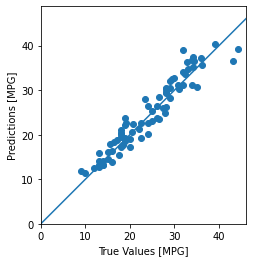

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

最后查看了误差的分布，结果来看分布并不够随机。那是不是如果模型足够好的话，误差应该要足够随机才可以呢。

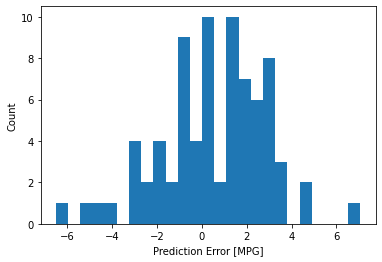

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## 总结
基本上这样就把构筑回归模型的思路走完了，整体来看的话，回归模型与分类模型在数据处理和模型构架方面差异并不大，差异很大的是在与模型训练时loss和metric的选择，要选择符合要求的。

最后还有一个关键点值得我思考的是：对于回归模型，要选择那种方式来去评价这个模型呢？有没有跟分类类似的ROC一样的工具来做评价呢？（ROC也可以，不过要设置cutoff）